<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-Random-Forest" data-toc-modified-id="Модель-Random-Forest-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель Random Forest</a></span></li><li><span><a href="#Обучим-модель-CatBoost" data-toc-modified-id="Обучим-модель-CatBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучим модель CatBoost</a></span></li><li><span><a href="#Обучим-модель-LightGBM" data-toc-modified-id="Обучим-модель-LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучим модель LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импорт библиотек

In [1]:
# Обработка данных
import pandas as pd
import numpy as np

# Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV, TimeSeriesSplit
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим пропуски.

In [5]:
data.isna().sum()

num_orders    0
dtype: int64

In [6]:
data.dropna(inplace = True)

Чтобы проверить, в хронологическом ли порядке расположены даты и время, посмотритим на атрибут индекса таблицы

In [7]:
data.index.is_monotonic

True

Посмотрим на минимальные и максимальные значения индексов.

In [8]:
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

Взглянем на график.

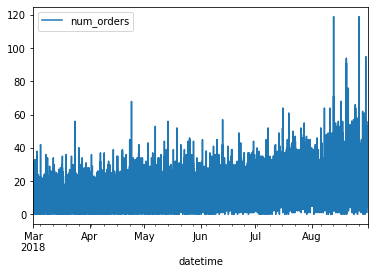

In [9]:
data.plot();

## Анализ

Выполним ресемплирование с интервалом 1 час.

In [10]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


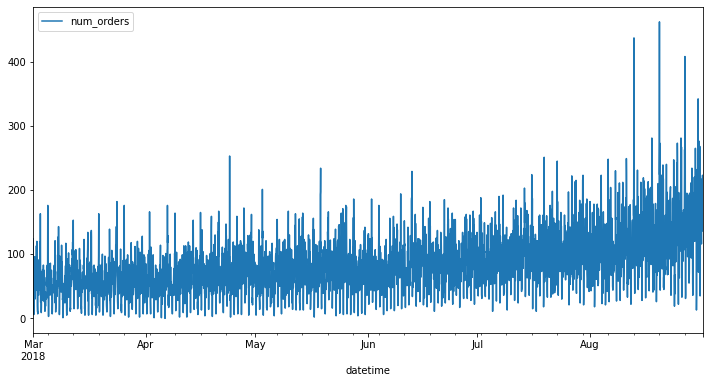

In [11]:
data.plot(figsize=(12,6));

Посмотрим на скользящее среднее

In [12]:
rolling_mean = data.rolling(10).mean()

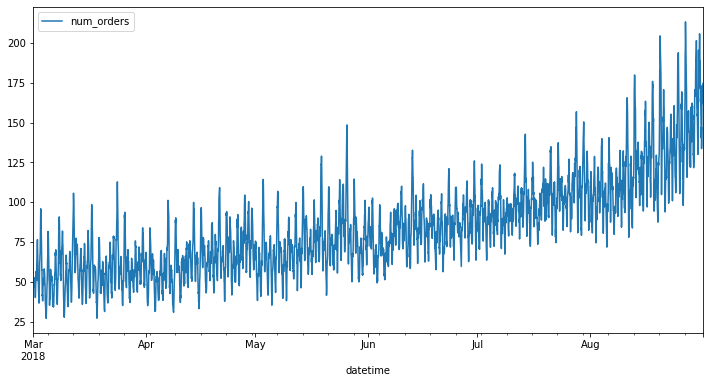

In [13]:
rolling_mean.plot(figsize=(12,6));

Посмотрим на тренды и сезонность

In [14]:
decomposed = seasonal_decompose(data)

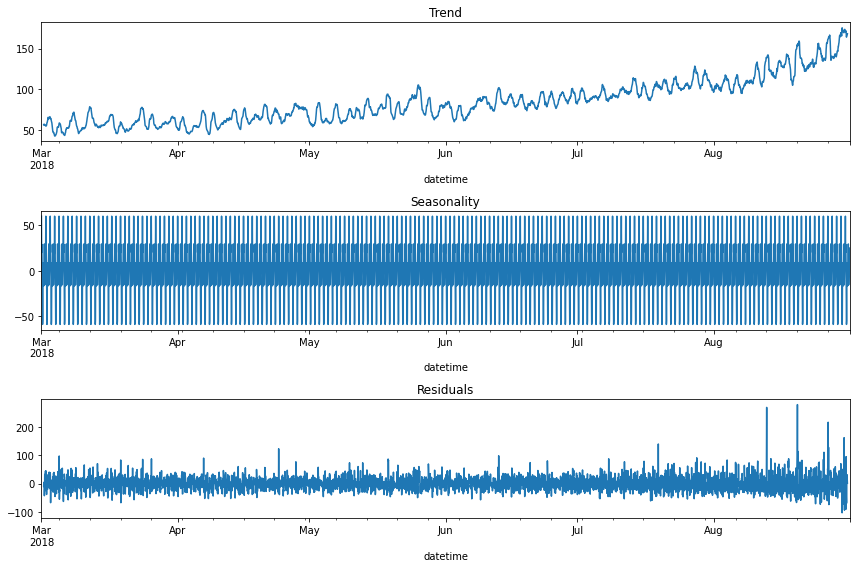

In [15]:
fig = plt.subplots(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Т.к у нас ресемплирование по одному часу, посмотрим, как меняется количество заказов в течение недели. Возьмём 1 неделю нескольких месяцев.

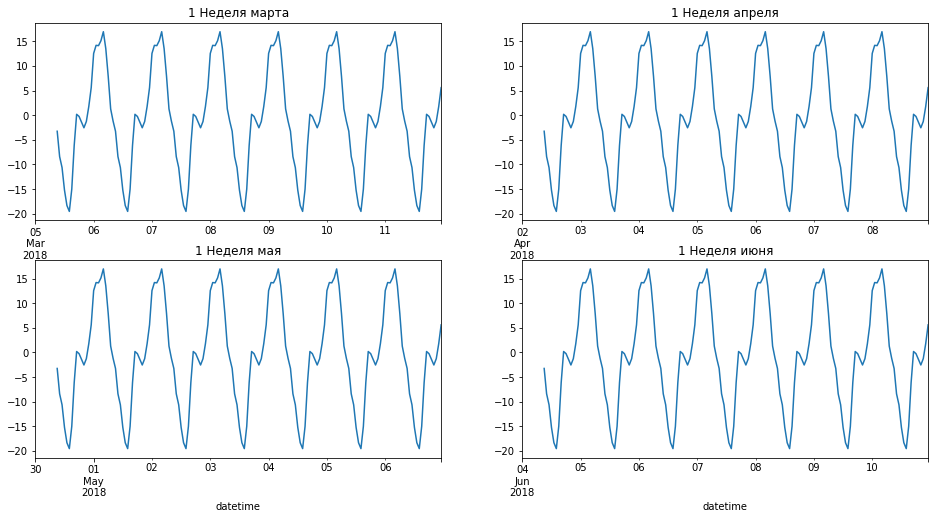

In [16]:
fig = plt.subplots(figsize=(16, 8))
plt.subplot(221)
decomposed.seasonal['2018-03-05':'2018-03-11'].rolling(10).mean().plot(title='1 Неделя марта', ax=plt.gca());
plt.subplot(222)
decomposed.seasonal['2018-04-02':'2018-04-08'].rolling(10).mean().plot(title='1 Неделя апреля', ax=plt.gca());
plt.subplot(223)
decomposed.seasonal['2018-04-30':'2018-05-06'].rolling(10).mean().plot(title='1 Неделя мая', ax=plt.gca());
plt.subplot(224)
decomposed.seasonal['2018-06-4':'2018-06-10'].rolling(10).mean().plot(title='1 Неделя июня', ax=plt.gca());

Взглянем поближе как меняется спрос в течения дня.

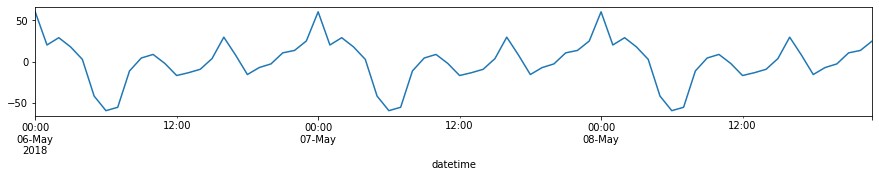

In [17]:
decomposed.seasonal['2018-05-06':'2018-05-08'].plot(figsize=(15, 2), ax=plt.gca());

**Вывод:** Мы выполним ресемплирование с интервалом 1 час. Построили график с трендами и сезонностью. На графике "Trend" наблюдаем, что летом увеличивается количество заказов. Так же посмотрели, как меняется спроса в течения дня. Наблюдаем уменьшения спроса под утро - 6:00 и увеличение ближе к полуночи с небольшими перепадами.

## Обучение

In [18]:
STATE = np.random.RandomState(12345)

Создадим признаки для горизонта прогнозирования. Признаками будет 1 час - задача проекта и неделя. Год и месяц не подойдут, не большой период, день не сильно будет видна тенденция. Так же добавим скользящее среднее и разность временного ряда.

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

In [20]:
make_features(data, 9, 9)

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,170.000000
2018-08-31 20:00:00,154,20,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,163.888889
2018-08-31 21:00:00,159,21,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,162.444444


In [21]:
# Разобьем на обучающую и тестовую выборку.

train, test = train_test_split(make_features(data, 9, 9), shuffle=False, test_size=0.1)
train = train.dropna()

In [22]:
train

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 09:00:00,69,9,3,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,50.666667
2018-03-01 10:00:00,64,10,3,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,44.555556
2018-03-01 11:00:00,96,11,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,42.222222
2018-03-01 12:00:00,30,12,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,45.000000
2018-03-01 13:00:00,32,13,3,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,41.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,137,9,0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,162.222222
2018-08-13 10:00:00,156,10,0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,159.666667
2018-08-13 11:00:00,144,11,0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,146.666667


In [23]:
features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

In [24]:
print('Количество строк на обучающей выборке', features_train.shape[0])
print('Количество строк на тестовую выборку', features_test.shape[0])

Количество строк на обучающей выборке 3965
Количество строк на тестовую выборку 442


### Модель Random Forest

In [25]:
# Фиксируем временной интервал

tscv = TimeSeriesSplit(n_splits=3)

In [26]:
forest_model =RandomForestRegressor(random_state = STATE)

parametr_set = {'max_depth': [10, 30, 50], 
                'min_samples_split': [2, 3, 4], 
                'min_samples_leaf': [10, 20]
               }

model_forest = GridSearchCV(estimator=forest_model, param_grid=parametr_set, 
                               scoring='neg_mean_squared_error', cv = tscv)

In [27]:
%%time

model_forest.fit(features_train, target_train)
print("Параметры:", model_forest.best_params_)
print('RMSE:', np.sqrt(-model_forest.best_score_))

Параметры: {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 2}
RMSE: 28.25277559098524
CPU times: user 39.2 s, sys: 156 ms, total: 39.3 s
Wall time: 39.3 s


### Обучим модель CatBoost

In [28]:
cat_model = CatBoostRegressor(verbose=False)

parameters_cat = {'iterations':[50, 100],
                  'learning_rate':[0.1, 0.3, 0.7],
                  'l2_leaf_reg':[3, 4, 6]
                 }

model_cat = GridSearchCV(estimator=cat_model, param_grid=parameters_cat, 
                               scoring='neg_mean_squared_error', cv = tscv)

In [29]:
%%time

model_cat.fit(features_train, target_train)
print("Параметры:", model_cat.best_params_)
print('RMSE:', np.sqrt(-model_cat.best_score_))

Параметры: {'iterations': 100, 'l2_leaf_reg': 6, 'learning_rate': 0.3}
RMSE: 27.86388683218474
CPU times: user 9.55 s, sys: 587 ms, total: 10.1 s
Wall time: 37.7 s


### Обучим модель LightGBM

In [30]:
light_model = LGBMRegressor(verbosity= -1, random_state = STATE, n_jobs=4)

parameters_light = {'num_leaves': [10, 30, 50, 100], 'max_depth': [5, 20, 30, 50], 
                    'learning_rate':[0.1, 0.5, 0.8]}

model_light = GridSearchCV(estimator=light_model, param_grid=parameters_light, scoring='neg_mean_squared_error', cv = tscv)

In [31]:
%%time

model_light.fit(features_train, target_train)
print("Параметры:", model_light.best_params_)
print('RMSE:', np.sqrt(-model_light.best_score_))

Параметры: {'learning_rate': 0.1, 'max_depth': 30, 'num_leaves': 50}
RMSE: 27.766773245859426
CPU times: user 1min 34s, sys: 2.16 s, total: 1min 36s
Wall time: 1min 37s


**Итог:** Лучший результат RMSE показывает модель LightGBM. **RMSE: 27.76**. 

## Тестирование

Проверяем на тестовой выборке нашу модель.

In [32]:
%%time

predict_light = model_light.best_estimator_.predict(features_test)
mse = mean_squared_error(target_test, predict_light)
rmse = np.sqrt(mse)
rmse

CPU times: user 16.8 ms, sys: 223 µs, total: 17 ms
Wall time: 14 ms


45.657906123851525

Сравненим с dummy моделью.

In [33]:
baseline_model = DummyRegressor()
baseline_model.fit(features_train, target_train)
predicted_test = baseline_model.predict(features_test)
mse = mean_squared_error(target_test, predicted_test)
print("RMSE:", np.sqrt(mse))

RMSE: 84.69882415876955


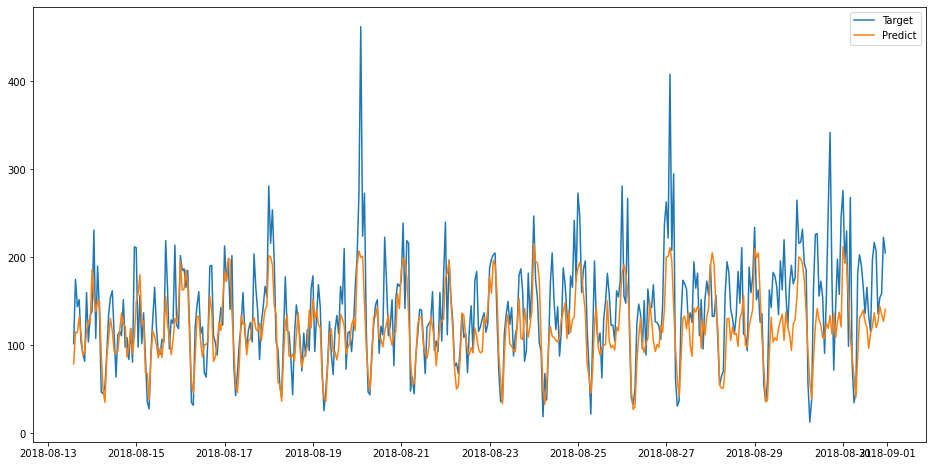

In [34]:
fig = plt.subplots(figsize=(16, 8))

plt.plot(target_test, label = 'Target')
plt.plot(target_test.index, predict_light, label = 'Predict')
plt.legend();

**Вывод:** Задачей нашего провекта было спрогнозировать количество заказов такси на следующий час. Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки.
**Критерий который важен заказчику:** RMSE на тестовой выборке должно быть не больше 48.
Были предоставеклнны данные с 2018-03-01 до 2018-08-31 с итервалом 10 мин, т.к. прогноз будет на следущий час мы выполнили ресемплирование с интервалом 1 час.
По трендам и сезонности было выявлено, что начиная с июня количество заказов растет. Так же что в течение дня спрос увеличивается начиная с 6:00 утра и до 0:00.

Мы ознакомились с данными и обучили 3 модели. 

1-я модель **Random Forest** получили следующие результаты: RMSE: 28.25

2-я модель **CatBoost** получили следующие результаты: RMSE: 27.86

3-я модель **LightGBM** получили следующие результаты: RMSE: 27.76

Для дальнейшего анализа мы выбрали модель **LightGBM** и на тестовой выборке получили RMSE: 45.65 что является приемлемым для нас. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48